# Week 4 NLP Disaster Tweets Kaggle Mini-Project


## Step1: Brief description of the problem and data

For this mini-project, we will be creating a model that determines if a person's post on X (formally Twitter) is discussing a disaster. This is relevant for disaster relief organizations and news reporters. We will be employing natural language processing techniques with the help of a recurrent neural network (RNN). We will also compare the results of our RNN against a Long Short-Term Memory (LSTM) model (which is a type of RNN) and a deep neural network (DNN). 
<br>
<br>
The data came from this kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started/data. 
<br>
<br>
The dataset contains three files: 'test.csv', 'train.csv', and 'sample_submission.csv'. The sample submission is the expected output of our project in order to submit to kaggle. The train and test csv files contain the text of a tweet, the keyword from this tweet (which may be blank), the location the tweet was sent from, and a unique id number for each tweet. In the train.csv file there is an additional column labeled target, which will tell us if it's from a real disaster or not. This will be denoted by a 1 or 0 respectively. 
<br>

## Step 2: Exploratory Data Analysis (EDA) — Inspecting, Visualizing, and Cleaning our Data

<br>
The first thing we will do is import the data into a dataframe. We will examine the head, count the features, and see if there are any oppurtunities for data cleaning procedures. We will also import all the libraries we will use for this project.

### Inspection
The first thing we will do is import all the libraries we will use for this project, load the data, and examine the dataframe heads.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(train_data.head())
print(test_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


As we can see from the heads, the train and test dataframes look relatively similar, with the key exception being the target column in train. Also, it's important to note that the keyword and location for the head are NaN values. This is ok and to be expected, as this was outlined in the data description on Kaggle.

### Visualization
Now, we are going to look and see how the tweets are tagged in our training data. If there is a huge imbalance, we may have to stratify our training/test split. We will also make a plot of the tweet lengths, to see if the is anything we can infer from the length of disaster tweets vs non-disaster tweets.

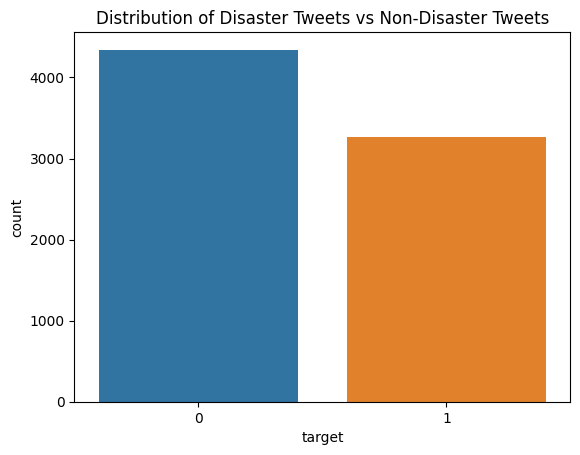

In [2]:
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster Tweets vs Non-Disaster Tweets')
plt.show()

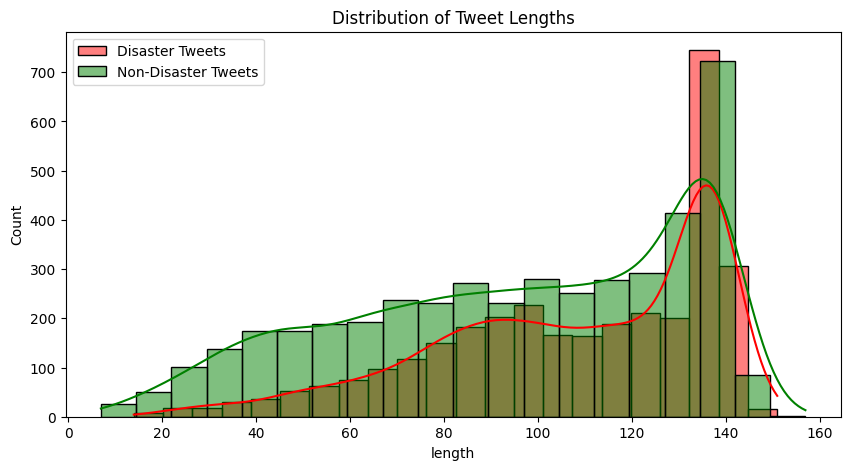

In [3]:
train_data['length'] = train_data['text'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(train_data[train_data['target'] == 1]['length'], color='red', label='Disaster Tweets', kde=True)
sns.histplot(train_data[train_data['target'] == 0]['length'], color='green', label='Non-Disaster Tweets', kde=True)
plt.title('Distribution of Tweet Lengths')
plt.legend()
plt.show()

There are slightly more non-disaster tweets than disaster tweets, but this should not present an issue. We can also see that the counts for the length of tweets have roughly the same distribution for disaster and non-disaster tweets. This is interesting, as I hypothesized that there may be more short tweets in the disaster tweets category, as people are trying to be concise and want to get information out quickly.

### Cleaning
For cleaning there are several steps that need to be done. We first need to see if there are any missing values in our dataset (with the exception of keyword and location, which we know could have missing values). Then we are going to clean our text data! This includes converting all our text to lowercase, removing URLs and special characters, and removing all the stop words. <br> Once our text is clean, we will then initialize a tokenizer. A tokenizer separates a piece of text into smaller units, called tokens. These tokens are needed as input for our neural network. The tokenizer will then be fitted, or trained, on the text. Then it will be converted to a train and test sequence. Finally, we will pad each of our sequences so that it has a consistent shape. This is important because our RNN will expect data to be of a consistent shape. 

In [4]:
missing_values = train_data.isnull().sum()
print(missing_values)

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64


In [5]:
train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

train_data['text'] = train_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)

nltk.download('stopwords')
stop = set(stopwords.words('english'))

train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
X_train_sequences = tokenizer.texts_to_sequences(train_data['text'])
X_test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train_padded = pad_sequences(X_train_sequences, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=X_train_padded.shape[1], padding='post')

y_train = train_data['target']
vocab_size = len(tokenizer.word_index) + 1

### Plan of Analysis
Now that the data is cleaned and tokenized, it is now ready for our models! We will start with our RNN and then move onto the other two. Once the models are complete we will observe the accuracy, validation accuracy, and confusion matrix for each model.

## Step 3: Model Architecture


### Reasoning for Model Selection
The reason that an RNN was chosen is because they are fully connected neural network, as it can retain information about previous steps. This is usful in this problem set because context is an important factor in deciding if something is a disaster related tweet or not. The basic structure is an input layer, a recurrent hidden layer, and an output layer.

### Model Construction
So let's get into the specifics! The first thing we have is our embedding layer, which takes in a vector of size 32. We then have our first simple RNN layer, which is where information is retained for future iterations. We then have a second RNN layer to further process our sequences. And finally we have a dense layer with parameters 1 (binary output) and activation sigmoid (which is the standard for binary classification tasks). Once the model is created, we then compile it with loss as binary_crossentropy, optimizer set to adam, and metrics set to accuracy. 

In [7]:
model_rnn = Sequential([
    Embedding(vocab_size, 32, input_length=X_train_padded.shape[1]),
    SimpleRNN(32, return_sequences=True),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 32)            536512    
                                                                 
 simple_rnn (SimpleRNN)      (None, 23, 32)            2080      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 540705 (2.06 MB)
Trainable params: 540705 (2.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Alternate Model Construction
The next two models that we will create will be our LSTM model and our DNN model. <br><br>
The LSTM model is similar to a RNN, however it is better designed for long-term dependencies than the standard RNN model. This is due to its utilization of its LSTM layer (as seen below). As you can see, this model's structure is very similar to our main model. I included this one because I am curious to see if it will outperform our standard RNN model. <br><br>
Lastly, we have a deep neural network. This one works slightly different than the other two. This one starts with an embedding layer just the same as the others, by this one reduces the dimensionality of the sequence by averaging over each time step. This basically summarizes the entire sequence. Then, that is fed into a 16 unit dense layer and then finally a binary dense layer as output. So rather than working on memory, this model works on averages. I'm curious to see if this radically different approach will outperform the other two models in our project.

In [8]:
model_lstm = Sequential([
    Embedding(vocab_size, 32, input_length=X_train_padded.shape[1]),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 32)            536512    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 544865 (2.08 MB)
Trainable params: 544865 (2.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model_dnn = Sequential([
    Embedding(vocab_size, 32, input_length=X_train_padded.shape[1]),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 32)            536512    
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 537057 (2.05 MB)
Trainable params: 537057 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Training and Predictions
Now we are ready to train our models! Each model will go through 5 epochs with a validation split of 0.1. Once they are fitted, a Kaggle submission will be generated and we will view the results in the next step. <br>
I predict that the lstm will perform the best, followed by our standard RNN, and then the DNN at the rear. Only one way to find out!

In [10]:
rnn_fitted = model_rnn.fit(X_train_padded, y_train, epochs=5, validation_split=0.1, batch_size=32)
lstm_fitted = model_lstm.fit(X_train_padded, y_train, epochs=5, validation_split=0.1, batch_size=32)
dnn_fitted = model_dnn.fit(X_train_padded, y_train, epochs=5, validation_split=0.1, batch_size=32)

Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5603 - accuracy: 0.7113 - val_loss: 0.4799 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2640 - accuracy: 0.9010 - val_loss: 0.5582 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1140 - accuracy: 0.9607 - val_loss: 0.6038 - val_accuracy: 0.7467
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0720 - accuracy: 0.9717 - val_loss: 0.7069 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0548 - accuracy: 0.9768 - val_loss: 0.8020 - val_accuracy: 0.7283
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5513 - accuracy: 0.7085 - val_loss: 0.4569 - val_accuracy: 0.8084
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2935 - accuracy: 0.8897 - val_loss: 0.5062 - val_accuracy: 0.7874
Epoch 

In [11]:
y_pred = model_rnn.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

submission = pd.DataFrame({'id': test_data['id'], 'target': y_pred})
submission.to_csv('submission_rnn.csv', index=False)

102/102 [==============================] - 1s 3ms/step


## Step 4: Results and Analysis
Let's take a look at the results! We will first observe the training loss/accuracy and the validation loss/accuracy for each model's final epoch. Then, we will plot each model's performance across each epoch. Then we will discuss our preliminary results.

In [22]:
def print_final_epoch_stats(history, model_name):
    final_train_loss = history.history['loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f"{model_name} Final Epoch Stats:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Validation Accuracy: {final_val_accuracy:.4f}")
    print("-"*40)

print_final_epoch_stats(rnn_fitted, "RNN Model")
print_final_epoch_stats(lstm_fitted, "LSTM Model")
print_final_epoch_stats(dnn_fitted, "DNN Model")

RNN Model Final Epoch Stats:
Training Loss: 0.0548
Training Accuracy: 0.9768
Validation Loss: 0.8020
Validation Accuracy: 0.7283
----------------------------------------
LSTM Model Final Epoch Stats:
Training Loss: 0.0964
Training Accuracy: 0.9708
Validation Loss: 0.6884
Validation Accuracy: 0.7375
----------------------------------------
DNN Model Final Epoch Stats:
Training Loss: 0.1726
Training Accuracy: 0.9391
Validation Loss: 0.4775
Validation Accuracy: 0.7874
----------------------------------------


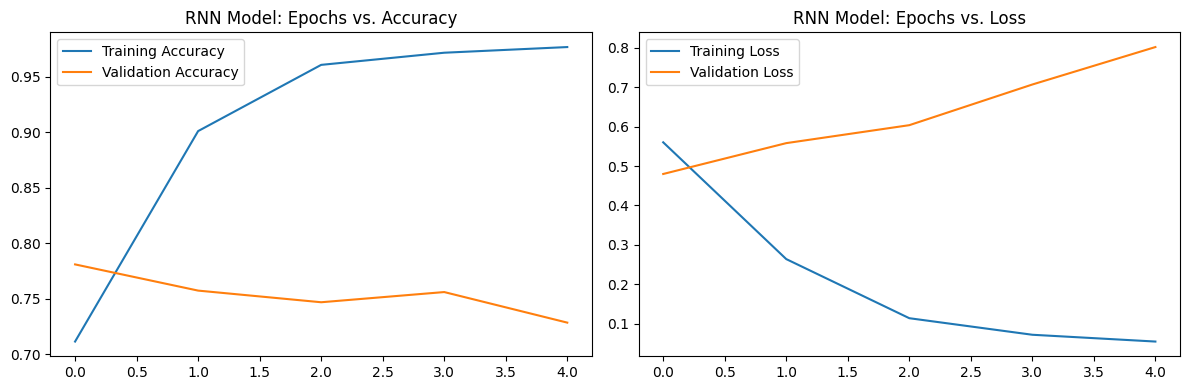

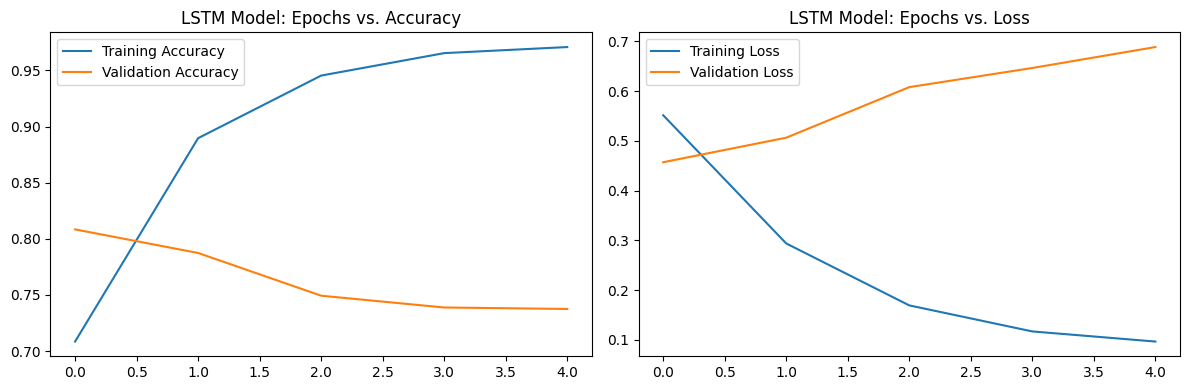

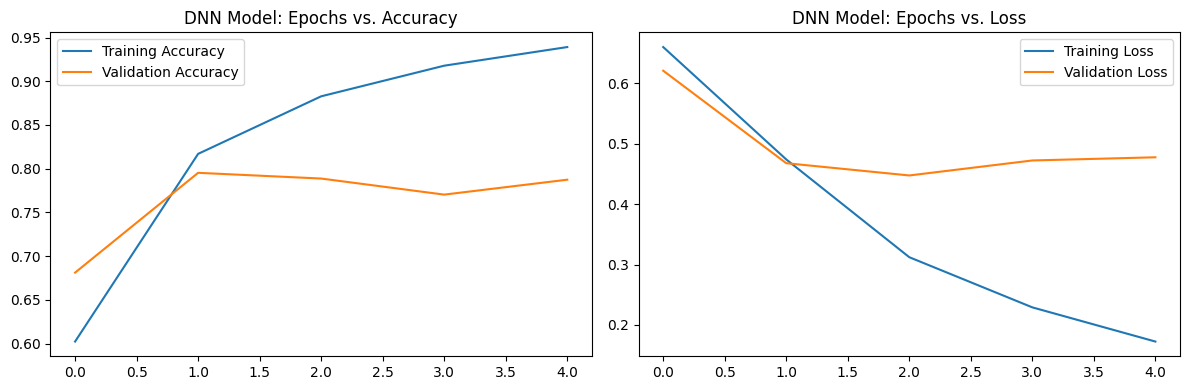

In [12]:
def plot_model_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name}: Epochs vs. Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name}: Epochs vs. Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(rnn_fitted, "RNN Model")
plot_model_history(lstm_fitted, "LSTM Model")
plot_model_history(dnn_fitted, "DNN Model")


238/238 [==============================] - 0s 2ms/step


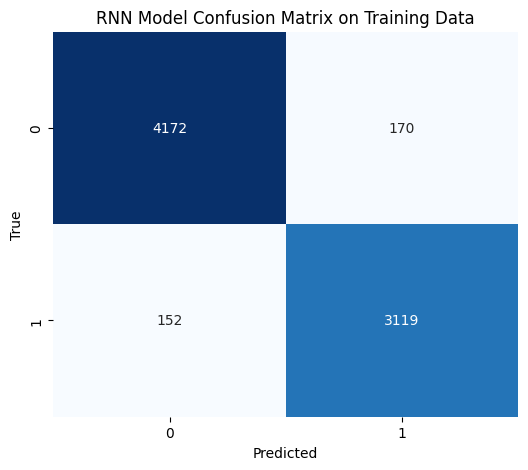

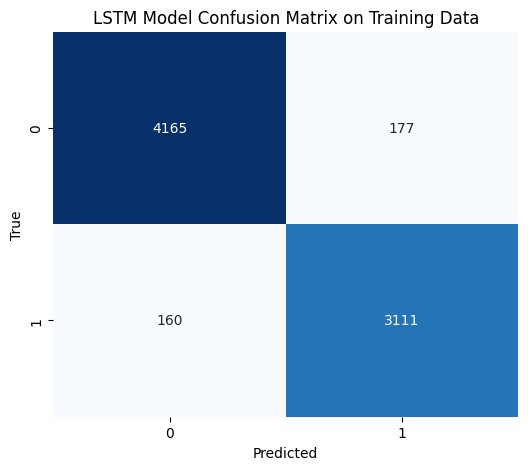

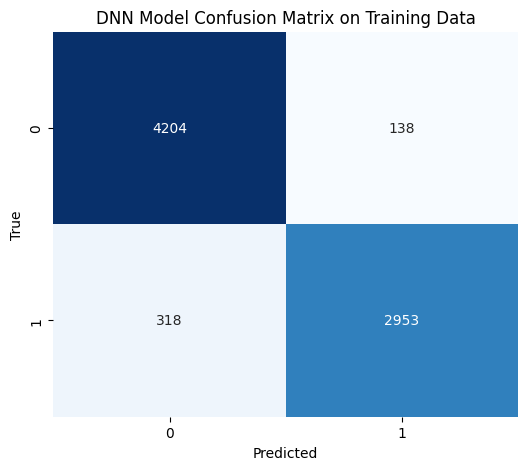

In [13]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_pred_train_rnn = (model_rnn.predict(X_train_padded) > 0.5).astype(int)
y_pred_train_lstm = (model_lstm.predict(X_train_padded) > 0.5).astype(int)
y_pred_train_dnn = (model_dnn.predict(X_train_padded) > 0.5).astype(int)

plot_confusion_matrix(y_train, y_pred_train_rnn, title='RNN Model Confusion Matrix on Training Data')
plot_confusion_matrix(y_train, y_pred_train_lstm, title='LSTM Model Confusion Matrix on Training Data')
plot_confusion_matrix(y_train, y_pred_train_dnn, title='DNN Model Confusion Matrix on Training Data')

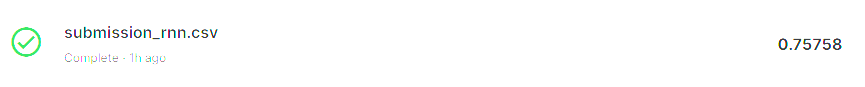

In [25]:
from IPython.display import Image
Image(filename="./sub_rnn.png")

Some pretty mixed results! We can see that the RNN seems to be overfitting the most, with the largest gap between training and validation accuracy. The LSTM model performed nearly identically to the RNN, with the LSTM slightly edging it out performance-wise. Of the three models we can see that the DNN performed best on the validation set. This result was fairly surprising, as it's a much more simple model. From each confusion matrix we can see that there doesn't appear to be evidence of over-classifying for any of the models, so that is good. For our Kaggle result, our RNN scored a 0.75758. Not too shabby, but we can do better, which leads us into...

### Hyperparameter Tuning & Attempts to Improve Performance
Let's try to make our RNN even better! We can do this by tuning our hyper parameters. We will utilize keras tuner's RandomSearch method to help us in this task. This code will take our base RNN model and use different hyperparameter combinations in order to identify the best possible model. Once it finds the most optimal model, we will run an analysis of this model against our previous RNN and compare the results. 

In [18]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, hp.Int("embedding_dim", min_value=16, max_value=128, step=16), input_length=X_train_padded.shape[1]))
    model.add(SimpleRNN(units=hp.Int("rnn_units", min_value=16, max_value=128, step=16), return_sequences=True))
    model.add(SimpleRNN(units=hp.Int("rnn_units", min_value=16, max_value=128, step=16)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=3,  
    directory='my_dir',
    project_name='kerastuner_rnn_example')

tuner.search_space_summary()

tuner.search(X_train_padded, y_train, epochs=5, validation_split=0.1)

Trial 5 Complete [00h 00m 28s]
val_accuracy: 0.5529308915138245

Best val_accuracy So Far: 0.7773403326670328
Total elapsed time: 00h 03m 15s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

rnn_tuned = best_model.fit(X_train_padded, y_train, epochs=5, validation_split=0.1, batch_size=32)

y_pred_tuned = best_model.predict(X_test_padded)
y_pred_tuned = (y_pred_tuned > 0.5).astype(int).reshape(-1)

submission_tuned = pd.DataFrame({'id': test_data['id'], 'target': y_pred_tuned})
submission_tuned.to_csv('submission_rnn_tuned.csv', index=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 80)            1341280   
                                                                 
 simple_rnn (SimpleRNN)      (None, 23, 80)            12880     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 80)                12880     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 1367121 (5.22 MB)
Trainable params: 1367121 (5.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.2442 - accuracy: 0.9098 - val_loss: 0.6156 - val_accuracy: 0.7244
Epoch 2/

### Model Performance
So how does our new model fair against our old one? Let's crunch the numbers and find out.

RNN Model Before Tuning Final Epoch Stats:
Training Loss: 0.0548
Training Accuracy: 0.9768
Validation Loss: 0.8020
Validation Accuracy: 0.7283
----------------------------------------
RNN Model After Tuning Final Epoch Stats:
Training Loss: 0.0518
Training Accuracy: 0.9764
Validation Loss: 0.7752
Validation Accuracy: 0.7336
----------------------------------------


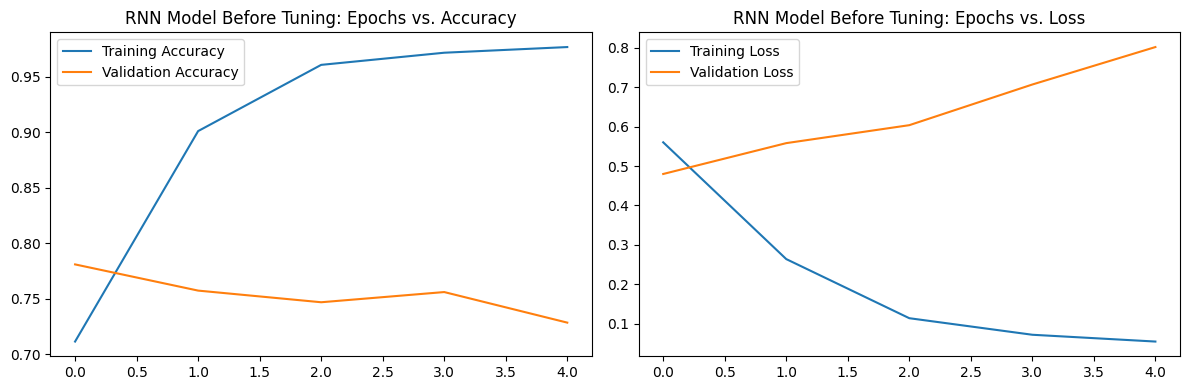

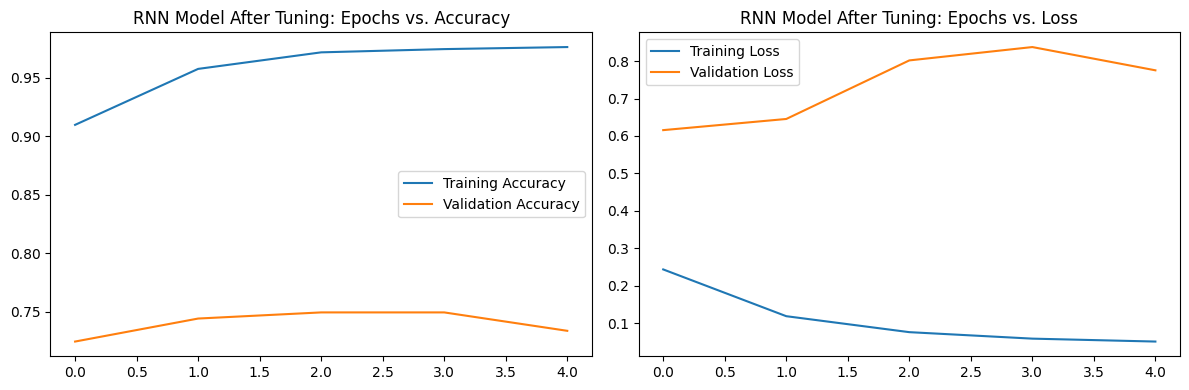

In [24]:
print_final_epoch_stats(rnn_fitted, "RNN Model Before Tuning")
print_final_epoch_stats(rnn_tuned, "RNN Model After Tuning")

plot_model_history(rnn_fitted, "RNN Model Before Tuning")
plot_model_history(rnn_tuned, "RNN Model After Tuning")

238/238 [==============================] - 0s 2ms/step


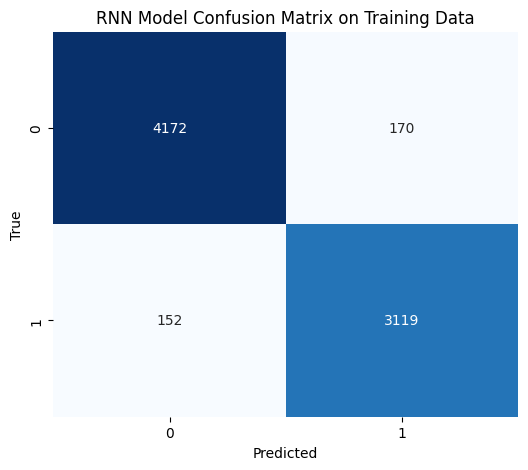

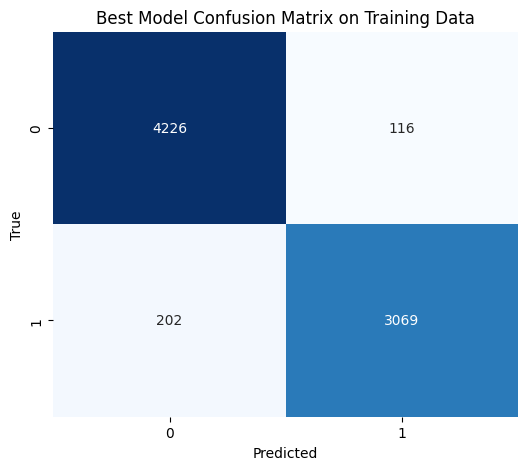

In [21]:
y_pred_train_best = (best_model.predict(X_train_padded) > 0.5).astype(int)

plot_confusion_matrix(y_train, y_pred_train_rnn, title='RNN Model Confusion Matrix on Training Data')
plot_confusion_matrix(y_train, y_pred_train_best, title='Best Model Confusion Matrix on Training Data')

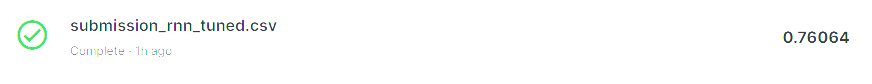

In [26]:
from IPython.display import Image
Image(filename="./sub_rnn_tuned.png")

Our model is better...but only slightly. There are indeed improvements made: the training loss is down slightly, the accuracy just about the same, validation loss is down, and the validation accuracy has improved to 73.36%. One thing of concern is that our training accuracy starts much higher than our base model, which may be a sign of overfitting. If we look to our Kaggle data, we can see that once again we do have improvement. It's just not as big of a jump as we would like. This small increase suggests that there may be further work needed in tuning our parameters, such as more trials or widening the scope of our random search.

## Step 5: Conclusion
<br>
Overall this project provided great insight into binary text classification, which many great takeaways. The first thing I tookaway is just how much importance and effort is needed in order to properly prepare text data for processing. I also was shocked at the performance of our DNN model, which goes to show that sometimes a more simple model can perform better than a complicated one (at least on some metrics). I also learned more about hyperparameter tuning than my previous project. And while it was good to actually see my model improve, I still think I have much to learn about the tuning process. <br> If I were to do this project again, I would experiment with different text cleaning procedures. Perhaps I could have improved my results if I had tokenized my data in a different way, like utilizing things like Word2Vec. I would also experiment with different models, such as an ensemble model, and see if that could improve performance. 